<a href="https://colab.research.google.com/github/Oreolorun/NeuralNetsPractice/blob/main/EndToEndPractice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#  mounting drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
#  unzipping dataset
!unzip gdrive/My\ Drive/Datasets/kagglecatsanddogs_3367a.zip > /dev/null

In [3]:
import numpy as np
from tqdm import tqdm, tqdm_notebook
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import cv2
import os

In [95]:
#  Initiate flag
rebuild_dataset = True

class DogsVSCats():
  def __init__(self):
    self.cats = 'PetImages/Cat'
    self.dogs = 'PetImages/Dog'
    self.labels = {self.cats:0, self.dogs:1}
    self.img_size = 50
    self.training_data = []
    self.cat_count = 0
    self.dog_count = 0

  def make_dataset(self):
    for label in self.labels:
      print(label)
      for file in tqdm(os.listdir(label)):
        try:
          path = os.path.join(label, file)
          image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
          image = cv2.resize(image, (self.img_size, self.img_size))
          image = np.array(image)
          self.training_data.append([image, np.eye(2)[self.labels[label]]])
          if label == self.cats:
            self.cat_count+=1
          elif label == self.dogs:
            self.dog_count+=1
        except Exception as e:
          pass
    np.random.shuffle(self.training_data)
    np.save('training_data.npy', self.training_data)
    print(f'\nCat Images: {self.cat_count}')
    print(f'Dog Images: {self.dog_count}')
    print(f'Total Number of Images: {self.cat_count+self.dog_count}')

if rebuild_dataset:
  dataset = DogsVSCats()
  dataset.make_dataset()
  dataset = np.load('training_data.npy', allow_pickle=True)
  print("Done!\nDataset data can now be found in object 'dataset'.\nRemember to reset flag to False")
  #  Flag manually changed to False

PetImages/Cat


100%|██████████| 12501/12501 [00:15<00:00, 798.04it/s]


PetImages/Dog


100%|██████████| 12501/12501 [00:16<00:00, 749.52it/s]
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)



Cat Images: 12476
Dog Images: 12470
Total Number of Images: 24946
Done!
Dataset data can now be found in object 'dataset'.
Remember to reset flag to False


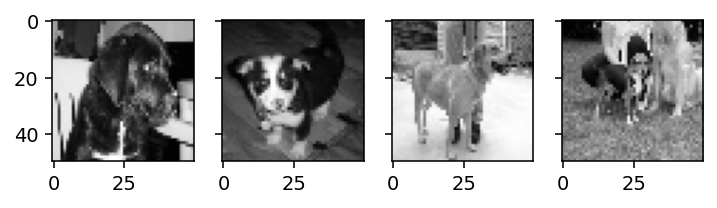

In [96]:
#  Displaying random images
figure, axes = plt.subplots(1,4, dpi=140, sharey=True)
axes[0].imshow(dataset[0][0], cmap='gray')
axes[1].imshow(dataset[4756][0], cmap='gray')
axes[2].imshow(dataset[10845][0], cmap='gray')
axes[3].imshow(dataset[23975][0], cmap='gray')

In [97]:
#  Defining function to split data
def split_data(data, split_pct):
  num_instances = len(data)
  split_size = int(num_instances*split_pct)
  idx = np.random.permutation(num_instances)
  return idx[:split_size], idx[split_size:]

#  Splitting into training, validation and test set
test_indices, data_indices = split_data(dataset, 0.1)
val_indices, train_indices = split_data(data_indices, 0.2)

In [98]:
training_data = dataset[train_indices]
validation_data = dataset[val_indices]
testing_data = dataset[test_indices]

In [99]:
training_data[0]

array([array([[146, 144, 141, ...,  54, 198, 196],
       [148, 144, 140, ..., 109, 140, 161],
       [150, 148, 143, ...,  84,  93, 119],
       ...,
       [ 62,  72,  83, ..., 126,  52,  61],
       [ 69,  83,  94, ...,  68, 150,  52],
       [ 87,  92,  99, ..., 107,  69, 158]], dtype=uint8),
       array([0., 1.])], dtype=object)

In [64]:
from torch.utils.data import DataLoader, SubsetRandomSampler, TensorDataset

#  Creating samplers
test_sampler = SubsetRandomSampler(test_indices)
val_sampler = SubsetRandomSampler(val_indices)
train_sampler = SubsetRandomSampler(train_indices)

#  Creating training, validation and testing dataloaders.
batch_size = 100
test_dl = DataLoader(dataset, sampler=test_sampler, batch_size=batch_size)
val_dl = DataLoader(dataset, sampler=val_sampler, batch_size=batch_size)
train_dl = DataLoader(dataset, sampler=train_sampler, batch_size=batch_size)

In [112]:
class Net(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1,32,5)
    self.conv2 = nn.Conv2d(32,64,5)
    self.conv3 = nn.Conv2d(64,128,5)
    self.fc1 = nn.Linear(128*2*2,512)
    self.fc2 = nn.Linear(512,2)
    self.pool = nn.MaxPool2d(2,2)

  def forward(self, x):
    x = x.view(-1,1,50,50)
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = self.pool(F.relu(self.conv3(x)))
    x = torch.flatten(x, 1)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    output = F.softmax(x, dim=1)
    return output

net = Net()

In [101]:
#  Spliting training data 
X_train = torch.Tensor([x[0] for x in training_data])
y_train = torch.Tensor([x[1] for x in training_data])

#  Spliting validation data
X_val = torch.Tensor([x[0] for x in validation_data])
y_val = torch.Tensor([x[1] for x in validation_data])

#  Spliting testing data
X_test = torch.Tensor([x[0] for x in testing_data])
y_test = torch.Tensor([x[1] for x in testing_data])

#  Scaling all pixels
X_train = X_train/225
X_val = X_val/225
X_test = X_test/225

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  


In [107]:
len(X_train)

17962

In [108]:
import torch.optim as optim

In [111]:
#  Training
loss_fn = nn.MSELoss()
optimiser = optim.Adam(net.parameters(), lr=0.001)

batch_size = 100
epochs = 4

for epoch in range(epochs):
  for i in tqdm_notebook(range(0, len(X_train), batch_size)):
    batch_x = X_train[i:i+batch_size]
    batch_y = y_train[i:i+batch_size]
    model.zero_grad()
    outputs = net(batch_x)
    loss = loss_fn(outputs.float(), batch_y.float())
    loss.backward()
    optimiser.step()
  print(f'Epoch: {epoch+1}/{epochs}\tLoss: {loss}')

Epoch: 0/4


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


  0%|          | 0/180 [00:00<?, ?it/s]

Epoch: 1/4


  0%|          | 0/180 [00:00<?, ?it/s]

Epoch: 2/4


  0%|          | 0/180 [00:00<?, ?it/s]

Epoch: 3/4


  0%|          | 0/180 [00:00<?, ?it/s]